# Analysis of [Compass](https://github.com/YosefLab/Compass) results

In [166]:
# taken from https://github.com/YosefLab/Compass/blob/docs/notebooks/compass_analysis.ipynb
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon, mannwhitneyu, ranksums
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hcluster
from scipy.spatial.distance import squareform

def cohens_d(x, y):
    pooled_std = np.sqrt(((len(x)-1) * np.var(x, ddof=1) 
                          + (len(y)-1) * np.var(y, ddof=1)) / 
                             (len(x) + len(y) - 2))
    return (np.mean(x) - np.mean(y)) / pooled_std
    

def wilcoxon_test(consistencies_matrix, group_A_cells, group_B_cells):
    """
        Performs an unpaired wilcoxon test (or mann-whitney U test) for each reaction between group_A and group_B
    """
    #per reaction/meta-reaction, conduct wilcoxon test between group_A and group_B
    group_A = consistencies_matrix.loc[:,group_A_cells]
    group_B = consistencies_matrix.loc[:,group_B_cells]
    results = pd.DataFrame(index = consistencies_matrix.index, columns = ['wilcox_stat', 'wilcox_pval', 'cohens_d'], dtype='float64')
    for rxn in consistencies_matrix.index:
        A, B = group_A.loc[rxn].to_numpy().ravel(), group_B.loc[rxn].to_numpy().ravel()
        stat, pval = mannwhitneyu(A, B, alternative='two-sided')
        c_d = cohens_d(A, B)
        results.loc[rxn, ['wilcox_stat', 'wilcox_pval', 'cohens_d']] = stat, pval, c_d
    results['adjusted_pval'] = np.array(multipletests(results['wilcox_pval'], method='fdr_bh')[1], dtype='float64')
    return results

def get_reaction_consistencies(compass_reaction_penalties, min_range=1e-3):
    """
        Converts the raw penalties outputs of compass into scores per reactions where higher numbers indicate more activity
    """
    df = -np.log(compass_reaction_penalties + 1)
    df = df[df.max(axis=1) - df.min(axis=1) >= min_range]
    df = df - df.min().min()
    return df

def get_metareactions(reactions, height=0.02):
    """
        Returns an array of metareaction labels for each reaction
        Index k in the returned array has the metareaction label for reaction k.
    """
    #pairwise_reaction_correlations = reactions.T.corr(method='spearman') #Pandas method here is orders of magnitude slower
    pairwise_reaction_correlations = np.corrcoef(reactions.rank(axis=1))
    #Unfortunately due to floating point issues, these matrices are not always perfectly symmetric and the diagonal may be slightly off from 1
    pairwise_reaction_correlations[np.arange(reactions.shape[0]), np.arange(reactions.shape[0])] = 1.0
    pairwise_reaction_correlations = (pairwise_reaction_correlations + pairwise_reaction_correlations.T)/2
    assert(np.all(pairwise_reaction_correlations == pairwise_reaction_correlations.T))

    Z = hcluster.complete(squareform(1 - pairwise_reaction_correlations))
    return hcluster.fcluster(Z, height, criterion='distance')

relevant_subsystems = [
    'Fatty acid oxidation', 
    'Arachidonic acid metabolism',
    'Glycerophospholipid metabolism',
    'Sphingolipid metabolism',
    'Glycolysis/gluconeogenesis', 
    'Oxidative phosphorylation',
    'Pyrimidine synthesis',
    'Pyrimidine catabolism',
    'beta-Alanine metabolism'
]

# custom functions
def filter_reactions(
    rxn_penalties, 
    reaction_metadata,
    relevant_subsystems,
    label1, 
    label2, 
    filter_subsystems = True,
    filter_confidence = True
):
    for r in rxn_penalties.index:
        if r in reaction_metadata.index:
            rxn_penalties.loc[r, 'metadata_r_id'] = r
        elif r[:-4] in reaction_metadata.index:
            rxn_penalties.loc[r, 'metadata_r_id'] = r[:-4]
        else:
            print("Should not occur")
            
    rxn_penalties = rxn_penalties.merge(
        reaction_metadata, 
        how = 'left',
        left_on = 'metadata_r_id', 
        right_index = True, 
        validate = 'm:1'
    )
    if filter_subsystems and not filter_confidence:
        rxn_penalties = rxn_penalties.loc[
            rxn_penalties.subsystem.isin(relevant_subsystems),
            rxn_penalties.columns.str.match(f'^{label1}|^{label2}')
        ]
    
    elif filter_confidence and not filter_subsystems:
        rxn_penalties = rxn_penalties.loc[
            rxn_penalties.confidence.isin([0, 4]),
            rxn_penalties.columns.str.match(f'^{label1}|^{label2}')
        ]
    
    elif filter_confidence and filter_subsystems:
        rxn_penalties = rxn_penalties.loc[
            rxn_penalties.confidence.isin([0, 4]) &
            rxn_penalties.subsystem.isin(relevant_subsystems),
            rxn_penalties.columns.str.match(f'^{label1}|^{label2}')
        ]
        
    else:
        rxn_penalties = rxn_penalties.loc[
            :,
            rxn_penalties.columns.str.match(f'^{label1}|^{label2}')
        ]
    
    return rxn_penalties

def load_reactions(disease_reactions_file, control_reactions_file, disease_label, control_label):
    ddf = pd.read_csv(
        disease_reactions_file,
        sep = '\t',
        index_col = 0,
        compression = 'gzip'
    )
    cdf = pd.read_csv(
        control_reactions_file,
        sep = '\t',
        index_col = 0,
        compression = 'gzip'
    )
    for df, label in zip([ddf, cdf], [disease_label, control_label]):
        df.columns = ['_'.join([label, column]) for column in df.columns]
        
    df = ddf.merge(
        cdf,
        how = 'left',
        left_index = True,
        right_index = True
    )
    return df

In [167]:
# only need to be run if you didn't download it yet
#!wget https://github.com/YosefLab/Compass/raw/docs/notebooks/extdata/RECON2/reaction_metadata.csv -O ../compass/recon2_reaction_metadata.csv

In [168]:
reaction_metadata = pd.read_csv(
    "../compass/recon2_reaction_metadata.csv", 
    index_col = 0
)
reaction_metadata

reaction_name  \
reaction_no_direction                                               
10FTHF5GLUtl               5-glutamyl-10FTHF transport, lysosomal   
10FTHF5GLUtm           5-glutamyl-10FTHF transport, mitochondrial   
10FTHF6GLUtl               6-glutamyl-10FTHF transport, lysosomal   
10FTHF6GLUtm           6-glutamyl-10FTHF transport, mitochondrial   
10FTHF7GLUtl               7-glutamyl-10FTHF transport, lysosomal   
...                                                           ...   
MAL_Lte                                     Transport of L-malate   
OROTGLUt                                                 OROTGLUt   
PNTOte                              Transport of (R)-Pantothenate   
IDOURte                      L-iduronate transport, extracellular   
EX_idour(e)                               Exchange of L-iduronate   

                                                                 formula  \
reaction_no_direction                                                      
10FTHF5GLUtl           1.00 * 10-formyltetrahydrofolate-[Glu](5) [c] ...   
10FTHF5GLUtm           1.00 * 10-formyltetrahydrofolate-[Glu](5) [m] ...   
10FTHF6GLUtl           1.00 * 10-formyltetrahydrofolate-[Glu](6) [c] ...   
10FTHF6GLUtm           1.00 * 10-formyltetrahydrofolate-[Glu](6) [m] ...   
10FTHF7GLUtl           1.00 * 10-formyltetrahydrofolate-[Glu](7) [c] ...   
...                                                                  ...   
MAL_Lte                1.00 * (S)-malate(2-) [e] --> 1.00 * (S)-malat...   
OROTGLUt               1.00 * L-glutamate(1-) [c] + 1.00 * Orotate [e...   
PNTOte                 1.00 * (R)-Pantothenate [e] --> 1.00 * (R)-Pan...   
IDOURte                1.00 * L-iduronate [e] --> 1.00 * L-iduronate ...   
EX_idour(e)                       1.00 * L-iduronate [e] --> ϕ\nNo genes   

                      associated_genes                 subsystem EC_number  \
reaction_no_direction                                                        
10FTHF5GLUtl                       NaN      Transport, lysosomal       NaN   
10FTHF5GLUtm                       NaN  Transport, mitochondrial       NaN   
10FTHF6GLUtl                       NaN      Transport, lysosomal       NaN   
10FTHF6GLUtm                       NaN  Transport, mitochondrial       NaN   
10FTHF7GLUtl                       NaN      Transport, lysosomal       NaN   
...                                ...                       ...       ...   
MAL_Lte                            NaN  Transport, extracellular       NaN   
OROTGLUt                       SLC22A7  Transport, extracellular       NaN   
PNTOte                             NaN  Transport, extracellular       NaN   
IDOURte                            NaN  Transport, extracellular       NaN   
EX_idour(e)                        NaN  Exchange/demand reaction       NaN   

                       confidence  
reaction_no_direction              
10FTHF5GLUtl                  2.0  
10FTHF5GLUtm                  2.0  
10FTHF6GLUtl                  2.0  
10FTHF6GLUtm                  2.0  
10FTHF7GLUtl                  2.0  
...                           ...  
MAL_Lte                       NaN  
OROTGLUt                      NaN  
PNTOte                        NaN  
IDOURte                       NaN  
EX_idour(e)                   NaN  

[7440 rows x 6 columns]

In [169]:
reaction_metadata[reaction_metadata.associated_genes.apply(lambda x: x.startswith('SLC7A5') if type(x) == str else False)]

reaction_name  \
reaction_no_direction                                                      
r1544                  Amino Acid-Polyamine-Organocation (APC) TCDB:2...   
r1546                  Amino Acid-Polyamine-Organocation (APC) TCDB:2...   
r1547                  Amino Acid-Polyamine-Organocation (APC) TCDB:2...   
r1548                  Amino Acid-Polyamine-Organocation (APC) TCDB:2...   
r1549                  Amino Acid-Polyamine-Organocation (APC) TCDB:2...   
...                                                                  ...   
r1658                  Amino Acid-Polyamine-Organocation (APC) TCDB:2...   
r1659                  Amino Acid-Polyamine-Organocation (APC) TCDB:2...   
r1660                  Amino Acid-Polyamine-Organocation (APC) TCDB:2...   
r1661                  Amino Acid-Polyamine-Organocation (APC) TCDB:2...   
r1662                  Amino Acid-Polyamine-Organocation (APC) TCDB:2...   

                                                                 formula  \
reaction_no_direction                                                      
r1544                  1.00 * L-glutamine [c] + 1.00 * Glycine [e] --...   
r1546                  1.00 * Glycine [e] + 1.00 * L-methionine [c] -...   
r1547                  1.00 * Glycine [e] + 1.00 * L-tryptophan [c] -...   
r1548                  1.00 * Glycine [e] + 1.00 * L-phenylalanine [c...   
r1549                  1.00 * Glycine [e] + 1.00 * L-tyrosine [c] -->...   
...                                                                  ...   
r1658                  1.00 * L-valine [e] + 1.00 * L-homoserine [c] ...   
r1659                  1.00 * L-valine [e] + 1.00 * L-isoleucine [c] ...   
r1660                  1.00 * L-threonine [e] + 1.00 * L-homoserine [...   
r1661                  1.00 * L-threonine [e] + 1.00 * L-isoleucine [...   
r1662                  1.00 * L-homoserine [e] + 1.00 * L-isoleucine ...   

                      associated_genes                 subsystem EC_number  \
reaction_no_direction                                                        
r1544                           SLC7A5  Transport, extracellular       NaN   
r1546                           SLC7A5  Transport, extracellular       NaN   
r1547                           SLC7A5  Transport, extracellular       NaN   
r1548                           SLC7A5  Transport, extracellular       NaN   
r1549                           SLC7A5  Transport, extracellular       NaN   
...                                ...                       ...       ...   
r1658                           SLC7A5  Transport, extracellular       NaN   
r1659                           SLC7A5  Transport, extracellular       NaN   
r1660                           SLC7A5  Transport, extracellular       NaN   
r1661                           SLC7A5  Transport, extracellular       NaN   
r1662                           SLC7A5  Transport, extracellular       NaN   

                       confidence  
reaction_no_direction              
r1544                         0.0  
r1546                         0.0  
r1547                         0.0  
r1548                         0.0  
r1549                         0.0  
...                           ...  
r1658                         0.0  
r1659                         0.0  
r1660                         0.0  
r1661                         0.0  
r1662                         0.0  

[111 rows x 6 columns]

In [170]:
np.sort(reaction_metadata.subsystem.unique())

array(['Alanine and aspartate metabolism', 'Alkaloid synthesis',
       'Aminosugar metabolism',
       'Androgen and estrogen synthesis and metabolism',
       'Arachidonic acid metabolism', 'Arginine and Proline Metabolism',
       'Bile acid synthesis', 'Biotin metabolism',
       'Blood group synthesis', 'Butanoate metabolism',
       'C5-branched dibasic acid metabolism', 'Cholesterol metabolism',
       'Chondroitin sulfate degradation', 'Chondroitin synthesis',
       'Citric acid cycle', 'CoA catabolism', 'CoA synthesis',
       'Cysteine Metabolism', 'Cytochrome metabolism',
       'D-alanine metabolism', 'Dietary fiber binding',
       'Eicosanoid metabolism', 'Exchange/demand reaction',
       'Fatty acid oxidation', 'Fatty acid synthesis',
       'Folate metabolism', 'Fructose and mannose metabolism',
       'Galactose metabolism', 'Glutamate metabolism',
       'Glutathione metabolism', 'Glycerophospholipid metabolism',
       'Glycine, serine, alanine and threonine metabo

## scRNA results

In [171]:
quant = 'novarino_tpm'
filepaths = [
    f'../compass/{quant}/neurons_wt',
    f'../compass/{quant}/neurons_ko'
]
reaction_penalties = load_reactions(
    *['/'.join([path, 'reactions.tsv.gz']) for path in filepaths],
    *['WT', 'KO']
)
reaction_penalties = filter_reactions(
    reaction_penalties,
    reaction_metadata,
    relevant_subsystems,
    'WT', 'KO',
    filter_confidence = False,
    filter_subsystems = False
)
reaction_penalties

WT_wt_162325  WT_wt_162326  WT_wt_162328  \
10FTHF5GLUtl_pos          4678.597961   4488.640683   4323.561968   
10FTHF5GLUtm_pos         10372.228792   9767.045314   8417.528105   
10FTHF6GLUtl_pos          6224.639976   5946.312579   5736.332667   
10FTHF6GLUtm_pos         11581.514413  10788.900812   9209.490513   
10FTHF7GLUtl_pos          7462.204823   7130.711289   6703.212600   
...                               ...           ...           ...   
sink_pre_prot(r)_pos         0.000000      0.000000      0.000000   
sink_tetdec2coa(c)_neg      14.229461     15.435244     14.185435   
sink_tetdec2coa(c)_pos       0.000000      0.000000      0.000000   
sink_tetdece1coa(c)_neg     14.229461     15.435244     14.185435   
sink_tetdece1coa(c)_pos      0.000000      0.000000      0.000000   

                         WT_wt_162329  WT_wt_162338  WT_wt_162341  \
10FTHF5GLUtl_pos          4248.832408   4309.963060   4653.876236   
10FTHF5GLUtm_pos          8008.012328   9096.630532   9684.153893   
10FTHF6GLUtl_pos          5511.914639   5570.771169   6214.249413   
10FTHF6GLUtm_pos          8785.949453   9906.552378  10770.151701   
10FTHF7GLUtl_pos          6410.199874   6484.159063   7361.751805   
...                               ...           ...           ...   
sink_pre_prot(r)_pos         0.000000      0.000000      0.000000   
sink_tetdec2coa(c)_neg      13.067692     13.813125     16.011425   
sink_tetdec2coa(c)_pos       0.000000      0.000000      0.000000   
sink_tetdece1coa(c)_neg     13.067692     13.813125     16.011425   
sink_tetdece1coa(c)_pos      0.000000      0.000000      0.000000   

                         WT_wt_162343  WT_wt_162423  WT_wt_162438  \
10FTHF5GLUtl_pos          4041.079102   4522.123351   4278.073355   
10FTHF5GLUtm_pos          9636.822366   9786.524333   8433.908220   
10FTHF6GLUtl_pos          5191.136134   5969.649151   5577.940158   
10FTHF6GLUtm_pos         10628.952423  10812.672192   9365.781327   
10FTHF7GLUtl_pos          6117.807606   7076.235257   6632.658288   
...                               ...           ...           ...   
sink_pre_prot(r)_pos         0.000000      0.000000      0.000000   
sink_tetdec2coa(c)_neg      13.410660     13.974214     11.494509   
sink_tetdec2coa(c)_pos       0.000000      0.000000      0.000000   
sink_tetdece1coa(c)_neg     13.410660     13.974214     11.494509   
sink_tetdece1coa(c)_pos      0.000000      0.000000      0.000000   

                         WT_wt_162455  ...  KO_ko_162490  KO_ko_162503  \
10FTHF5GLUtl_pos          3820.280768  ...   4100.032362   4220.119065   
10FTHF5GLUtm_pos          8327.299986  ...   8888.786914   9241.089580   
10FTHF6GLUtl_pos          4934.484257  ...   5312.920136   5514.418428   
10FTHF6GLUtm_pos          9225.086631  ...   9809.658739  10186.456226   
10FTHF7GLUtl_pos          5883.432501  ...   6321.784118   6590.022030   
...                               ...  ...           ...           ...   
sink_pre_prot(r)_pos         0.000000  ...      0.000000      0.000000   
sink_tetdec2coa(c)_neg      12.263197  ...     10.652861     12.397476   
sink_tetdec2coa(c)_pos       0.000000  ...      0.000000      0.000000   
sink_tetdece1coa(c)_neg     12.263197  ...     10.652861     12.397476   
sink_tetdece1coa(c)_pos      0.000000  ...      0.000000      0.000000   

                         KO_ko_162519  KO_ko_162520  KO_ko_162521  \
10FTHF5GLUtl_pos          4361.849483   4420.321327   4097.783638   
10FTHF5GLUtm_pos          9637.896642   9385.156744   7983.365494   
10FTHF6GLUtl_pos          5698.714205   5855.072343   5317.635486   
10FTHF6GLUtm_pos         10649.405233  10543.210546   8758.626276   
10FTHF7GLUtl_pos          6701.892647   7061.070623   6247.418702   
...                               ...           ...           ...   
sink_pre_prot(r)_pos         0.000000      0.000000      0.000000   
sink_tetdec2coa(c)_neg      13.222667     12.435272     13.865875   
sink_tetdec2coa(c)_pos      

In [172]:
# aggregate meta reactions
# see also https://yoseflab.github.io/Compass/notebooks/Demo.html#Metareactions
rxn_penalties = reaction_penalties.copy() # copy to avoid modification of original
rxn_penalties[rxn_penalties <= 1e-4] = 0
rxn_penalties = rxn_penalties[
    np.all(rxn_penalties != 0, axis=1)
]
rxn_penalties = rxn_penalties[
    rxn_penalties.max(axis=1) - rxn_penalties.min(axis=1) != 0
]
meta_rxns_map = get_metareactions(rxn_penalties)
meta_rxn_penalties = rxn_penalties.join(
    pd.DataFrame(
        meta_rxns_map, 
        columns=["meta_rxn_id"], 
        index = rxn_penalties.index
    )
).groupby("meta_rxn_id").mean()
meta_rxn_penalties

WT_wt_162325  WT_wt_162326  WT_wt_162328  WT_wt_162329  \
meta_rxn_id                                                           
1             3698.271347   3527.449851   4116.666667   3887.567274   
2             2850.000000   2850.000000   2850.000000   2694.784184   
3             2850.000000   2169.165233   2850.000000   2694.784184   
4             2850.000000   2850.000000   2622.887931   2477.794280   
5             2850.000000   2306.051555   2692.567656   2512.036527   
...                   ...           ...           ...           ...   
1793          3343.533795   3208.745161   2962.716141   2998.054874   
1794          3166.666667   3166.666667   2962.716141   2895.765974   
1795          3415.682332   3800.000000   2962.716141   3800.000000   
1796          3274.303774   3800.000000   2962.716141   3800.000000   
1797          3274.303774   3800.000000   2962.716141   3800.000000   

             WT_wt_162338  WT_wt_162341  WT_wt_162343  WT_wt_162423  \
meta_rxn_id                                                           
1             3409.859563   2326.918209   3674.488839   4084.702848   
2             2672.519267    453.419237   2850.000000   2761.095612   
3             2672.519267    453.419237   2850.000000   2761.095612   
4             2850.000000    453.419237   2712.916243   2560.726172   
5             2850.000000   1448.630229   2712.916243   2560.726172   
...                   ...           ...           ...           ...   
1793          2945.875855   2927.785163   2106.184625   3106.873841   
1794          2945.875855   2893.500712   2106.184625   2988.160525   
1795          2945.875855   3800.000000   2106.184625   3800.000000   
1796          2945.875855   3800.000000   2944.556049   3800.000000   
1797          2945.875855   3800.000000   2106.184625   3800.000000   

             WT_wt_162438  WT_wt_162455  ...  KO_ko_162490  KO_ko_162503  \
meta_rxn_id                              ...                               
1             3709.281089   1701.231433  ...   2985.082570   3192.193471   
2             2722.388031    410.756073  ...   2504.079322   2642.181520   
3             2722.388031    410.756073  ...   2504.079322   2178.128296   
4             2847.334203    410.756073  ...   2820.745988   2473.314345   
5             2847.334203   1482.780111  ...   2831.422705   2386.342650   
...                   ...           ...  ...           ...           ...   
1793          2147.357939   2983.084327  ...   2189.493233   2969.015638   
1794          2147.357939   2983.084327  ...   2189.493233   2898.720079   
1795          2147.357939   2983.084327  ...   2189.493233   3800.000000   
1796          2973.678970   2983.084327  ...   2975.821541   3800.000000   
1797          2147.357939   2983.084327  ...   2189.493233   3800.000000   

             KO_ko_162519  KO_ko_162520  KO_ko_162521  KO_ko_162523  \
meta_rxn_id                                                           
1             2891.398577   3713.836327   2674.215367   2847.544134   
2             2563.550566   2796.651994    367.412858   2508.038526   
3             2563.550566   2796.651994    367.412858   2508.038526   
4             2563.550566   2735.504589    367.412858   2524.615252   
5             2563.550566   2769.119530   2022.470953   2524.615252   
...                   ...           ...           ...           ...   
1793          2957.614658   2960.473033   2960.267798   3107.930619   
1794          2957.614658   2960.473033   2960.267798   2977.455525   
1795          2957.614658   2960.473033   2960.267798   3308.731409   
1796          2957.614658   2960.473033   2960.267798   3133.220558   
1797          2957.614658   2960.473033   2960.267798   3133.220558   

             KO_ko_162534  KO_ko_162551  KO_ko_162553  KO_ko_162554  
meta_rxn_id                                                          
1             3117.070854   3941.350963   2857.579028   2742.966392  
2             2707.616646   2850.000000   

In [173]:
single_consistencies = get_reaction_consistencies(reaction_penalties)
meta_consistencies = get_reaction_consistencies(meta_rxn_penalties)

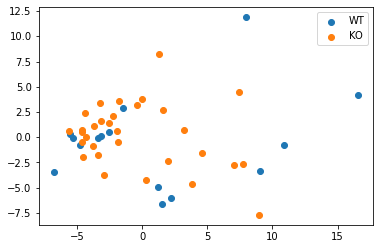

In [174]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components = 10)
data = pca.fit_transform(meta_consistencies.values.T)
fig, ax = plt.subplots()
for condition in ['WT', 'KO']:
    cond_idx = meta_consistencies.columns.str.startswith(condition)
    ax.scatter(
        data[cond_idx, 0], 
        data[cond_idx, 1],
        label = condition
    )
    ax.legend()

In [175]:
# meta_rxns_map contains the cluster id for each reaction in rxn_penalties
# to get the most contributing reactions for a given PC we need to sort the absolute
# values of the corresponding component and get the ids of features with the highest contributions
# these features are metareactions. Thus to get the corresponing reactions we have to find
# all indices in meta_rxns_map that have the given feature id
# correlations between PCs and reactions as shown in the heatmaps of the paper 
# seem to be computed via spearman correlation by correlating reaction consistencies of a given
# cell/cluster with the PC_X coordinate of the same cell
# i.e. spearman([reaction_i_cell_j, ...], [PC_X_cell_j, ...])

for i in range(10):
    most_contributing = np.abs(pca.components_[i]).argsort()[::-1][:10]
    reaction_idx = np.where(np.isin(meta_rxns_map, most_contributing))[0]
    print(reaction_metadata.loc[[i[:-4] for i in rxn_penalties.iloc[reaction_idx].index]].subsystem.unique())

['Transport, extracellular']
['Transport, extracellular']
['Transport, extracellular' 'Transport, peroxisomal']
['Transport, extracellular' 'Alanine and aspartate metabolism'
 'Exchange/demand reaction' 'Transport, mitochondrial'
 'Galactose metabolism']
['Transport, extracellular' 'Alanine and aspartate metabolism'
 'Transport, endoplasmic reticular' 'Methionine and cysteine metabolism'
 'Exchange/demand reaction' 'Folate metabolism'
 'Arginine and Proline Metabolism' 'Fructose and mannose metabolism'
 'Unassigned']
['Nucleotide interconversion' 'Transport, mitochondrial'
 'Exchange/demand reaction' 'Tyrosine metabolism' 'Citric acid cycle'
 'Pyruvate metabolism' 'Valine, leucine, and isoleucine metabolism'
 'Unassigned']
['Transport, mitochondrial' 'Exchange/demand reaction'
 'Glycolysis/gluconeogenesis' 'Valine, leucine, and isoleucine metabolism'
 'Inositol phosphate metabolism'
 'Phosphatidylinositol phosphate metabolism' 'Pentose phosphate pathway'
 'Glutathione metabolism' 'Unas

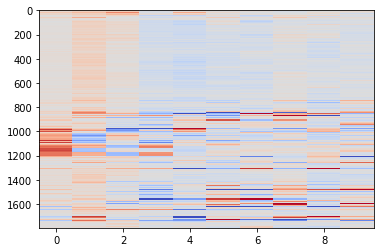

In [176]:
plt.imshow(pca.components_.T, aspect = 'auto', cmap = 'coolwarm', vmin = -0.1, vmax = 0.1, interpolation = 'none')

In [177]:
wilcox_test_results = {}
for aggregation, rcs, results in zip(
    ['single', 'meta'],
    [single_consistencies, meta_consistencies],
    [single_wilcox_test_results, meta_wilcox_test_results]
):
    disease_label, control_label = ['KO', 'WT']
    disease_clusters = rcs.columns[rcs.columns.str.startswith(disease_label)]
    control_clusters = rcs.columns[rcs.columns.str.startswith(control_label)]
    wilcox_results = wilcoxon_test(
        rcs, 
        disease_clusters, 
        control_clusters
    )
    if aggregation == 'meta':
        wilcox_results_expanded = pd.DataFrame(
            index = rxn_penalties.index, 
            columns = wilcox_results.columns
        )
        # wilcox_results_expanded contains index of single_rxn_penalties in same order
        for i in range(len(wilcox_results_expanded.index)):
            # meta_rxns_map[i] returns metareaction index for the given enumerated reaction
            if meta_rxns_map[i] in wilcox_results.index:
                wilcox_results_expanded.loc[wilcox_results_expanded.index[i]] = \
                    wilcox_results.loc[meta_rxns_map[i]]

        wilcox_results = wilcox_results_expanded.dropna().astype('float64')
                
    wilcox_results['metadata_r_id'] = ""
    for r in wilcox_results.index:
        if r in reaction_metadata.index:
            wilcox_results.loc[r, 'metadata_r_id'] = r
        elif r[:-4] in reaction_metadata.index:
            wilcox_results.loc[r, 'metadata_r_id'] = r[:-4]
        else:
            print("Should not occur")

    wilcox_test_results[aggregation] = wilcox_results.merge(
        reaction_metadata, 
        how = 'left',
        left_on = 'metadata_r_id', 
        right_index = True, 
        validate = 'm:1'
    )

In [178]:
# def write_results(wilcoxon_results, pval_cutoff, file):
#     results = wilcoxon_results[wilcoxon_results.adjusted_pval <= pval_cutoff].sort_values(
#         by = ['adjusted_pval', 'cohens_d']
#     )
#     results.to_csv(
#         file,
#         sep = '\t'
#     )
# for quant in quantifications:
#     for key, W in wilcoxon_test_results[quant].items():
#         write_results(
#             W,
#             0.01,
#             f'../compass/{quant}_{key}.signif.tsv'
#         )

In [179]:
import plotly.express as px
import plotly
from IPython.display import HTML
def plotly_vulcano_plot(
    data, title, 
    pval_cutoff = 0.01, 
    pval_column = 'adjusted_pval', 
    color = None, 
    xlims = (-1.5, 1.5)
):
    fig = px.scatter(
        data, 
        x = 'cohens_d', 
        y = -np.log10(data[pval_column]), 
        hover_name = 'reaction_name',
        labels = {
            'y': '-log10(adjusted p-value)',
            'cohens_d': "Cohen's D",
        },
        color = color if color else None,
        hover_data = ['associated_genes', 'subsystem'],
        title = title,
        opacity = 0.5,
        range_x = xlims
    )
    if pval_cutoff:
        fig.add_hline(
            y = -np.log10(pval_cutoff), 
            line_width = 1, 
            line_dash = 'dash'
        )
    fig.add_vline(
        x = 0, 
        line_width = 1, 
        line_dash = 'dash'
    )
    fig.update_layout(
        width = 1000,
        height = 950
    )
    return fig

def plotly_category_plot(
    data, 
    title, 
    relevant_subsystems = None, 
    xlims = (-1.5, 1.5)
):
    if relevant_subsystems:
        data = data.loc[data.subsystem.isin(relevant_subsystems), :].copy()
        
    data['color'] = data.cohens_d.apply(
        lambda x: 'upregulated' if x >= 0 else 'downregulated'
    )
    data = data.sort_values(
        by = 'color',
    )
    fig = px.scatter(
        data,
        y = 'subsystem',
        x = 'cohens_d',
        hover_name = 'reaction_name',
        labels = {
            'cohens_d': "Cohen's D"
        },
        color = data.color,
        range_x = xlims
    )
    return fig

def save_html(fig, filename):
    fig.write_html(filename)
    plotly.offline.plot(
        fig, 
        filename = filename
    )

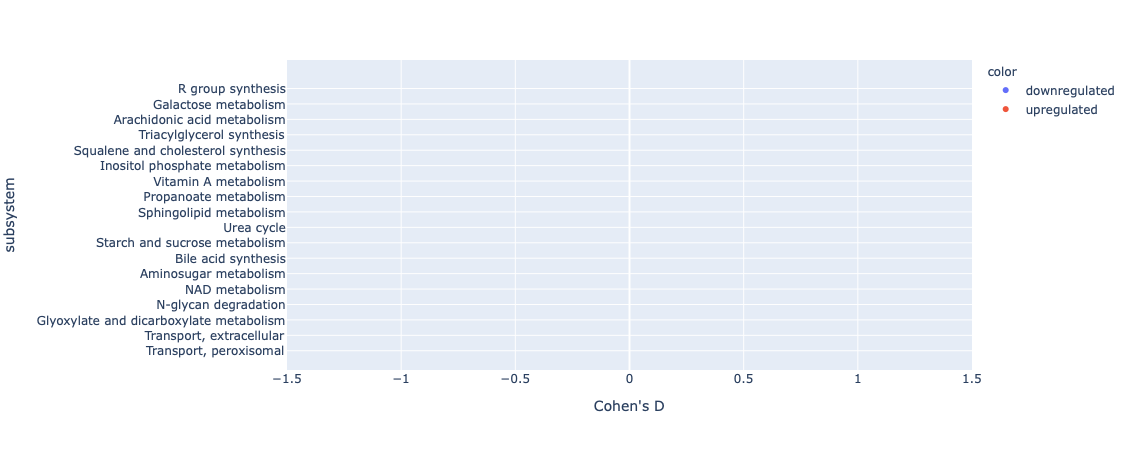

In [180]:
plotly_category_plot(
    wilcox_test_results['single'],
     'neurons' + ' ' + ' vs. '.join(['KO', 'WT']),
)

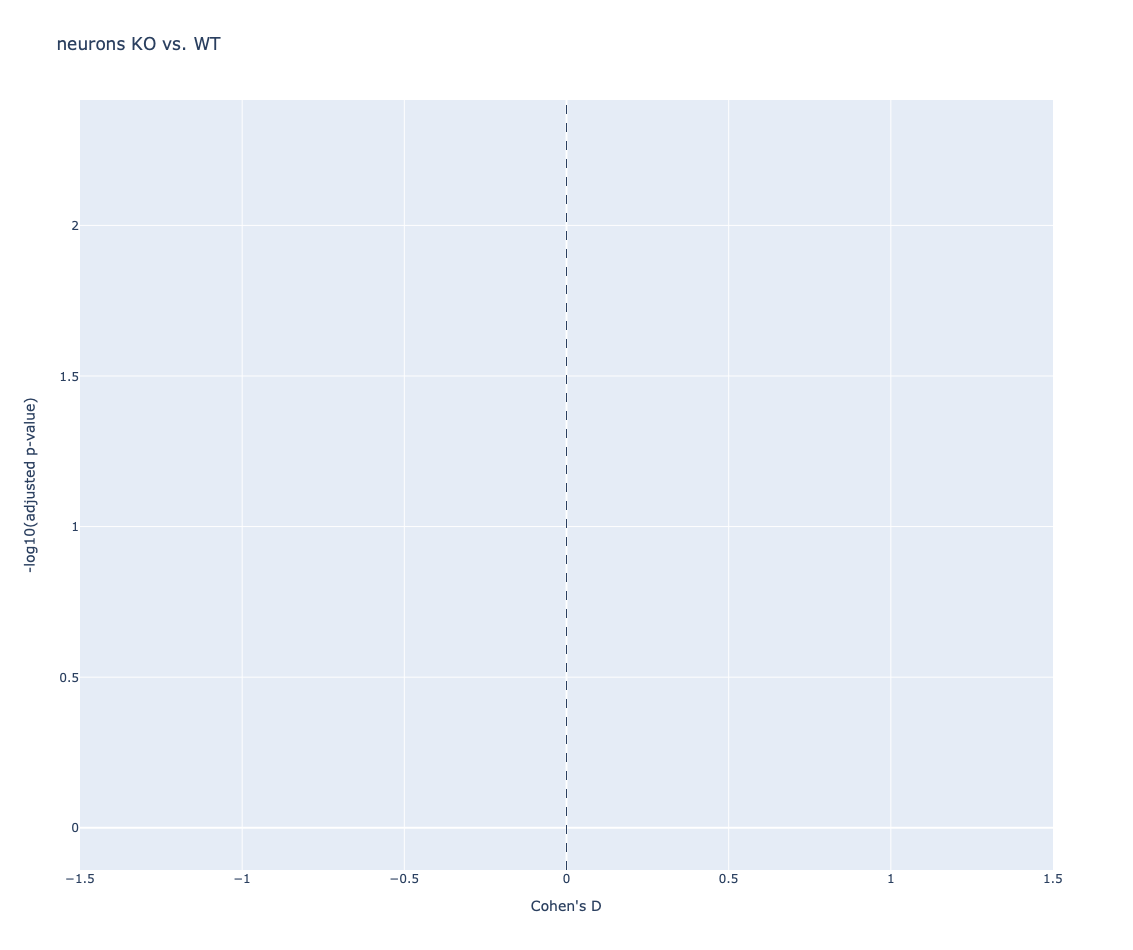

In [181]:
plotly_vulcano_plot(
    wilcox_test_results['single'],
    'neurons' + ' ' + ' vs. '.join(['KO', 'WT']),
    pval_cutoff = None,
    pval_column = 'wilcox_pval'
)

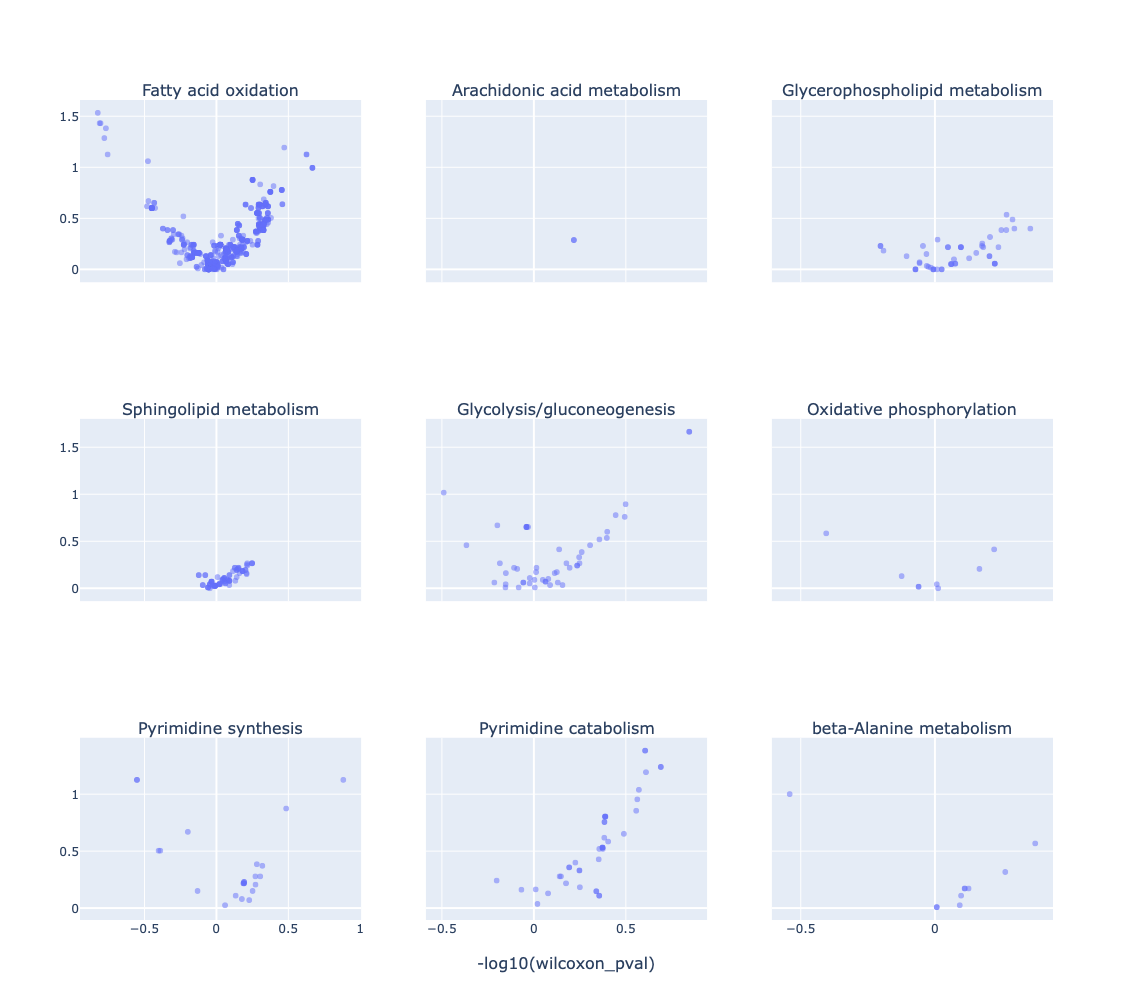

In [185]:
from plotly.subplots import make_subplots
fig = make_subplots(
    rows = 3, 
    cols = 3,
    subplot_titles = relevant_subsystems,
    shared_xaxes = True,
    shared_yaxes = True,
    x_title = '-log10(wilcoxon_pval)'
)
data = wilcox_test_results['single']
for i, j, subsystem in zip(
    [1, 1, 1, 2, 2, 2, 3, 3, 3], 
    [1, 2, 3, 1, 2, 3, 1, 2, 3], 
    relevant_subsystems):
    fig.add_trace(
        plotly_vulcano_plot(
            data[data.subsystem == subsystem],
            'neurons' + ' ' + ' vs. '.join(['KO', 'WT']) + subsystem,
            pval_cutoff = 0.05,
            pval_column = 'wilcox_pval'
        ).data[0],
        row = i, 
        col = j
    )
    
fig.update_layout(
    width = 1000,
    height = 1000
)
fig.show()

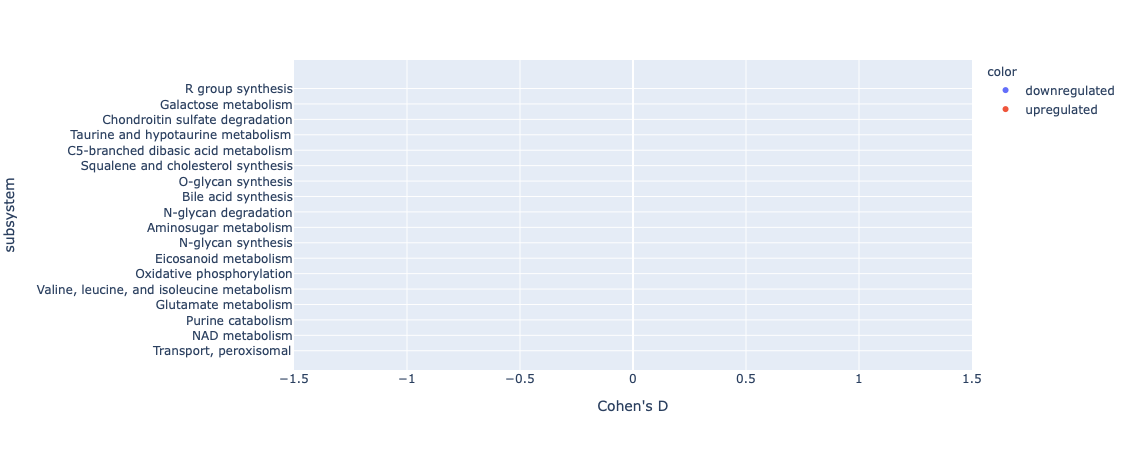

In [182]:
plotly_category_plot(
    wilcox_test_results['meta'],
     'neurons' + ' ' + ' vs. '.join(['KO', 'WT']),
)

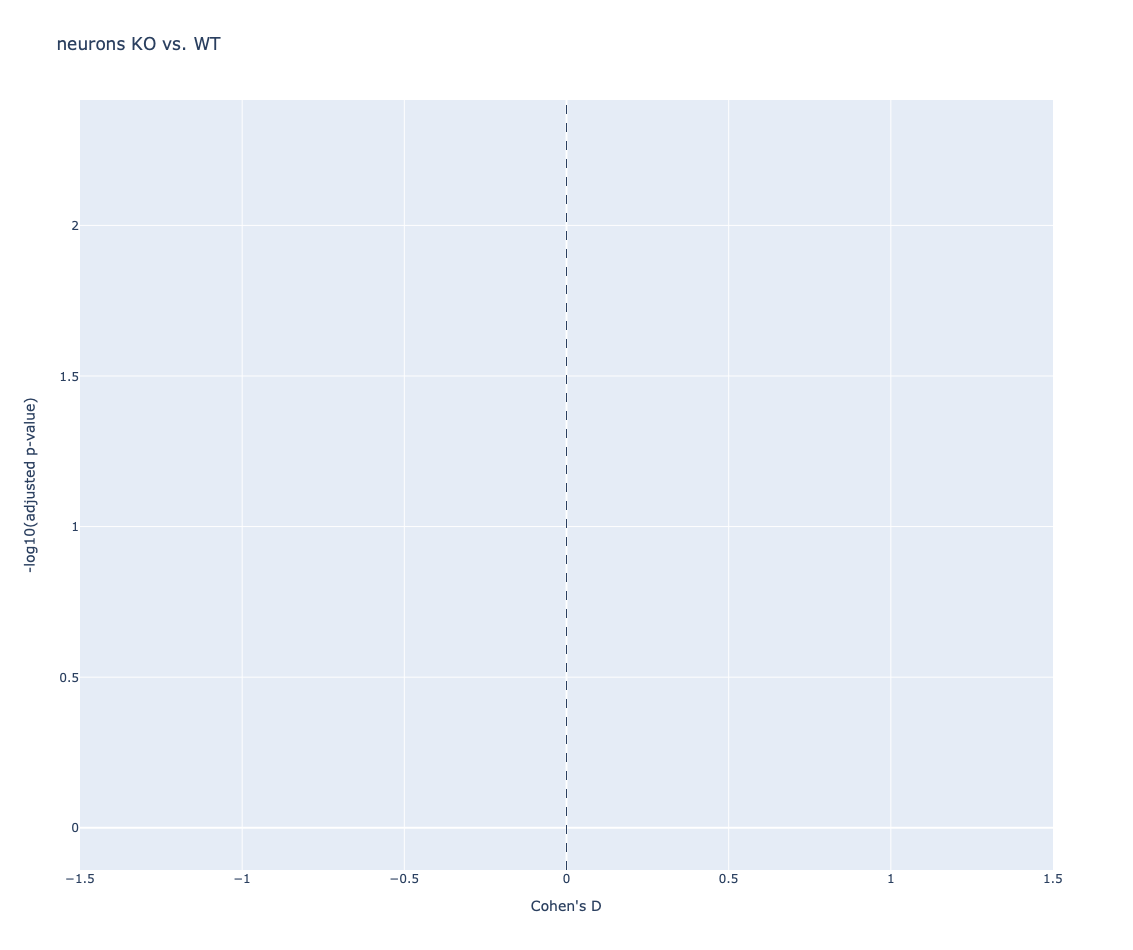

In [183]:
plotly_vulcano_plot(
    wilcox_test_results['meta'],
    'neurons' + ' ' + ' vs. '.join(['KO', 'WT']),
    pval_cutoff = None,
    pval_column = 'wilcox_pval'
)

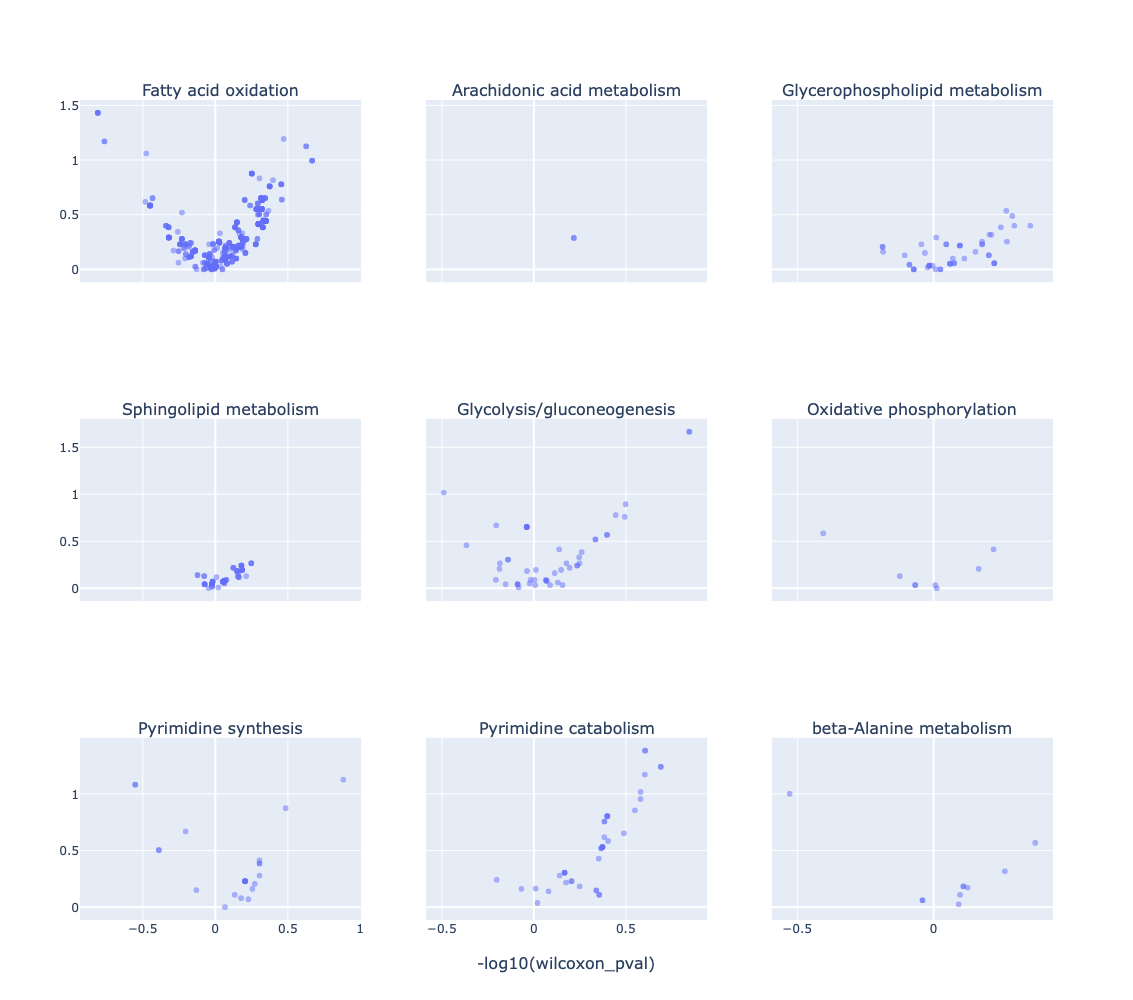

In [186]:
from plotly.subplots import make_subplots
fig = make_subplots(
    rows = 3, 
    cols = 3,
    subplot_titles = relevant_subsystems,
    shared_xaxes = True,
    shared_yaxes = True,
    x_title = '-log10(wilcoxon_pval)'
)
data = wilcox_test_results['meta']
for i, j, subsystem in zip(
    [1, 1, 1, 2, 2, 2, 3, 3, 3], 
    [1, 2, 3, 1, 2, 3, 1, 2, 3], 
    relevant_subsystems):
    fig.add_trace(
        plotly_vulcano_plot(
            data[data.subsystem == subsystem],
            'neurons' + ' ' + ' vs. '.join(['KO', 'WT']) + subsystem,
            pval_cutoff = 0.05,
            pval_column = 'wilcox_pval'
        ).data[0],
        row = i, 
        col = j
    )
    
fig.update_layout(
    width = 1000,
    height = 1000
)
fig.show()

# Write results to file

In [30]:
df = reaction_consistencies['novarino_tpm']['neurons'].copy()
df['logFC'] = df.loc[:, df.columns.str.startswith('KO')].median(axis = 1) / df.loc[:, df.columns.str.startswith('WT')].median(axis = 1)
df = df.loc[:, ['logFC']]

for r in df.index:
    if r in reaction_metadata.index:
        df.loc[r, 'metadata_r_id'] = r
    elif r[:-4] in reaction_metadata.index:
        df.loc[r, 'metadata_r_id'] = r[:-4]
    else:
        print("Should not occur")
                
df['ec_number'] = df.metadata_r_id.apply(
    lambda x: reaction_metadata.at[x, 'EC_number']
)
df.dropna(
    subset = ['ec_number'],
    inplace = True
)
df = df.sort_index()
df

logFC     metadata_r_id ec_number
13DAMPPOX_pos         1.016497         13DAMPPOX   1.4.3.6
2DR1PP_pos            1.011031            2DR1PP  3.1.3.10
2HBO_neg              1.009523              2HBO  1.1.1.27
2HBO_pos              0.999164              2HBO  1.1.1.27
2OXOADOXm_pos         0.997916         2OXOADOXm  2.3.1.61
...                        ...               ...       ...
r1487_pos             1.030900             r1487   6.2.1.3
r1488_pos             1.017051             r1488   6.2.1.3
r1492_pos             1.030697             r1492   6.2.1.3
sink_citr(c)_pos      1.019971      sink_citr(c)  2.4.99.9
sink_pre_prot(r)_neg  0.999260  sink_pre_prot(r)  2.4.99.9

[2146 rows x 3 columns]

In [31]:
df.to_csv(
    '../raw/compass_results_neurons.tsv',
    sep = '\t'
)